<h1 style='text-align: center; color:#00697f'> Diyabetik Retinopati - Körlük Tespiti </h1>
<h2 style='text-align: center; color:#00697f'> Görüntü Sınıflandırma EfficientNet-V2-L CNN modeli kullanımı  </h2>

<table style="text-align: center">
    <tr style="text-align: center">
        <td style="text-align: center; color:#00697f ">
            <h2>Inönü University Computer Engineering - Master's - Pattern Recognition </h2>
        </td>
        <td rowspan=3, style="text-align: center; color:#00697f">
            <img src="inonu_ai.png" width="100"/>
        </td>       
    </tr>
    <tr>
        <td style="text-align: center; color:#00697f">
            <h2>İnönü Üniversitesi - Bilgisayar Mühendisliği - Yüksek Lisans - Örüntü Tanıma Dersi </h2>
        </td>
    </tr>
    <tr>
        <td style="text-align: center">
            <h3> Dr. Ali ARI (Lecturer) - Ahmet BAĞBARS (Graduate Student) </h3>
        </td>
    </tr>
</table>

### 1. Importing Dependencies (En)  - Bağımlılıkları İçe Aktarma (Tr)

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers

from keras.applications import DenseNet121,DenseNet201
from tensorflow.keras import regularizers
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline

In [2]:
from keras.applications import EfficientNetV2L

### 2. DataSet Proccess (En) -  VeriSeti işlemleri (Tr)

<table style="border: 1px solid;">
    <tr>
    <th style="text-align: center" colspan=2>DataSet Descriptions - VeriSeti Açıklamaları </th> 
    </tr>
    <tr>
        <td>Aptos 2019 DR </td>
        <td>"https://www.kaggle.com/competitions/aptos2019-blindness-detection/data" </td>
    </tr>
    <tr>
        <td>Messidor-2-Resized</td>
        <td>"https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized" </td>
    </tr>    
    
</table>

In [ ]:
# Base Dataset Path Specification - Temel VeriSeti Tanımlamaları
DataSet_Folder=os.path.join('DR_DataSet')

### 2.1. Path Specifications for Aptos-2019 DR Dataset  (En)
> ### Aptos 2019 VeriSeti Yolu Tanımlamaları (Tr)

In [3]:
Aptos_DataSet_Folder=os.path.join(DataSet_Folder,'aptos2019-blindness-detection')
#TRAIN_DF_PATH = Veri_Seti_Yolu+'/train.csv'
Aptos_Train_DF = os.path.join(Aptos_DatasetFolder,'train.csv')
#TEST_DF_PATH = Veri_Seti_Yolu+'/test.csv'
Aptos_Test_DF=os.path.join(Aptos_DatasetFolder,'/test.csv')
#TRAIN_IMG_PATH = Veri_Seti_Yolu + "/train_images/"
#TEST_IMG_PATH = Veri_Seti_Yolu + '/test_images/'
Aptos_Train_Img_Path=os.path.join(Aptos_DataSet_Folder,'train_images')
Aptos_Test_Img_Path=os.path.join(Aptos_DataSet_Folder,'test_images')

In [4]:
# Veri Çerçevesi oluşturma
# train.csv ve text.csv veri çerçeveleri ile Veri Kümesinde train ve test resim dosyalarının bilgileri elde edilecektir. 
train_df = pd.read_csv(TRAIN_DF_PATH)
test_df = pd.read_csv(TEST_DF_PATH)
print (train_df.shape)
print (test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### 2.2. En: Path Specifications for Messidor-2-Resized (2240x1488 to 512x512 preprocessed) DR Dataset  
> ### Tr:Messidor-2-Yeniden Boyutlandırılmış (2240x1488 den 512x512'ye ve önişleme yapılmış) VeriSeti Yolu Tanımlamaları

In [ ]:
messidor=pd.read_csv("DR_DataSet/messidor_2_resized/messidor_data.csv")

In [6]:
eyepacs= pd.read_csv('DR_DataSet/eyepacsDRv2/trainLabels.csv')

In [5]:
# Specify image size
IMG_WIDTH = 480
IMG_HEIGHT = 480
CHANNELS = 3

In [6]:
# creating dataframes train and test
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)
# Add extension to id_code
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)
# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [7]:
# number of images in each class
train_df.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [8]:
# Labels for training data
y_labels = train_df['diagnosis'].values
y_labels[:5]

array([2, 4, 1, 0, 0], dtype=int64)

0    1805
1     370
2     999
3     193
4     295
Name: diagnosis, dtype: int64

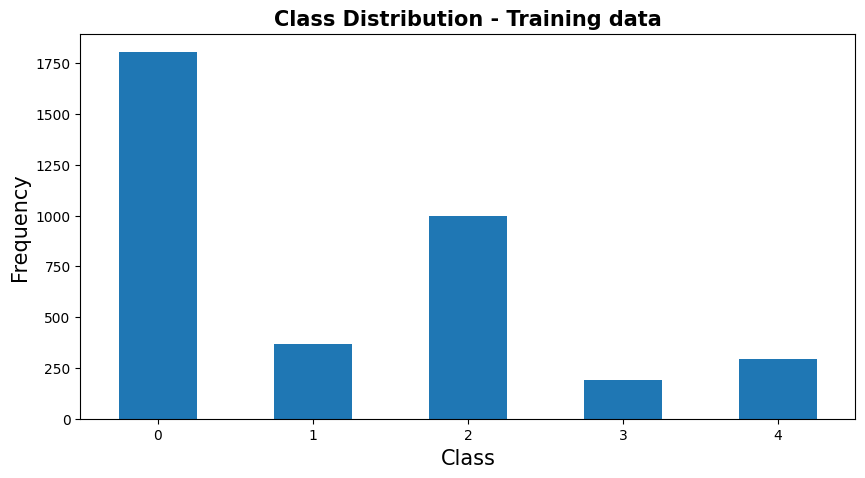

In [9]:
# EDA- distribution of classes in training dataset
import matplotlib.pyplot as plt
train_df.diagnosis.value_counts().sort_index().plot(kind = 'bar', figsize = (10,5), rot = 0)
plt.title('Class Distribution - Training data', weight = 'bold', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Class', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

train_df.diagnosis.value_counts().sort_index()

./aptos2019-blindness-detection/train_images/ef5155990874.png
./aptos2019-blindness-detection/train_images/d801c0a66738.png
./aptos2019-blindness-detection/train_images/6f0463c1ff18.png
./aptos2019-blindness-detection/train_images/3e3a3955b9c5.png
./aptos2019-blindness-detection/train_images/ed3a0fc5b546.png


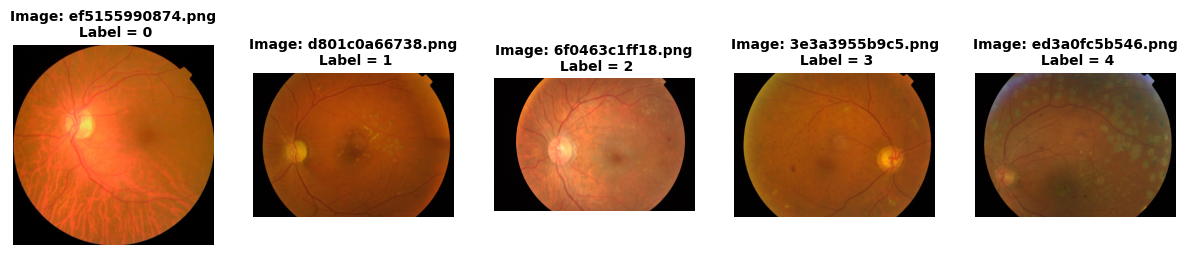

In [10]:

# taking a look at image from each class
import cv2
SEED = 42
fig, ax = plt.subplots(1,5,figsize = (15,5))
for i in range(5):
    sample = train_df[train_df.diagnosis == i].sample(1,random_state=SEED)
    image_name = sample['id_code'].item()
    X = cv2.imread(f'{TRAIN_IMG_PATH}{image_name}')
    print(f'{TRAIN_IMG_PATH}{image_name}')
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(cv2.cvtColor(X,cv2.COLOR_BGR2RGB))

Ben Graham's preprocessing method
Ben Graham (previous competition's winner) share insightful way to improve lighting condition. Here, we apply his idea, and can see many important details in the eyes much better.

In [11]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    #return image 
    return (tf.cast(image, dtype=tf.float32) - 128.00) / 128.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


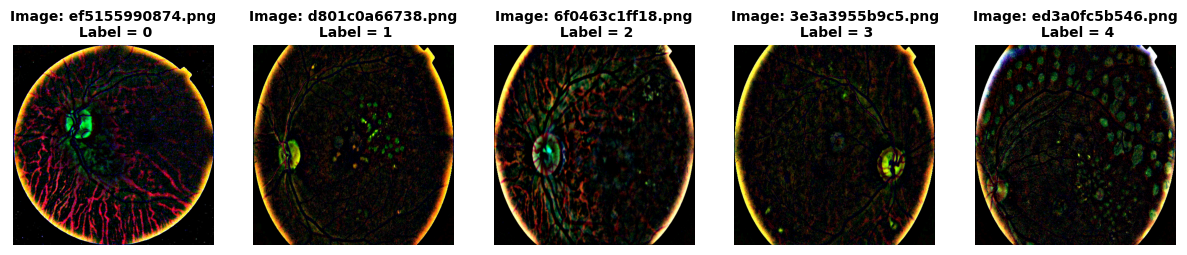

In [12]:
fig, ax = plt.subplots(1,5,figsize = (15,5))
for i in range(5):
    sample = train_df[train_df.diagnosis == i].sample(1,random_state=SEED)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f'{TRAIN_IMG_PATH}{image_name}'))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X)

In [13]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Model Kaydediliyor!.")
            self.model.save('model_effnetv2_l_epoch-{}_kappa-{}.h5'.format(epoch,round(_val_kappa, 4)))
        return

# Learning Rate Düşürücü eklendi

In [15]:
lr_dusurucu=ReduceLROnPlateau(monitor='val_loss',
                             patience=1,
                             verbose=1,
                             mode='auto',
                             factor=0.25,
                             min_lr=0.0000001)


In [16]:
# replace number to names
replace_map = {'diagnosis':{0:'No_DR',1:'Mild',2:'Moderate',3:'Severe',4:'Proliferate_DR'}}

In [17]:
train_df.replace(replace_map, inplace = True)
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,Moderate
1,001639a390f0.png,Proliferate_DR
2,0024cdab0c1e.png,Mild
3,002c21358ce6.png,No_DR
4,005b95c28852.png,No_DR


densenet=tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS),
    )

In [18]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,Moderate
1,001639a390f0.png,Proliferate_DR
2,0024cdab0c1e.png,Mild
3,002c21358ce6.png,No_DR
4,005b95c28852.png,No_DR


In [19]:
effnetv2_l=tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS),
)

In [20]:
# building model using Densenet-121
def build_model():
    model = Sequential()
    model.add(effnetv2_l)
    model.add(layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)),
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    #model.add(layers.Dense(1024,activation='relu')) #2.denemede eklendi
    model.add(layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu')),
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [21]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 15, 15, 1280)     117746848 
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 1280)     5120      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                        

In [22]:
# add image agumentation to our generator
BATCH_SIZE = 2
datagen = ImageDataGenerator(rotation_range = 360,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  validation_split = 0.15,
                                  preprocessing_function = preprocess_image,
                                  #rescale = 1/128.00
                                  )

train_generator = datagen.flow_from_dataframe(train_df, 
                                              x_col = 'id_code',
                                              y_col = 'diagnosis',
                                              directory = TRAIN_IMG_PATH,
                                              target_size = (IMG_WIDTH, IMG_HEIGHT),
                                              batch_size = BATCH_SIZE,
                                              class_mode="categorical",
                                              subset = 'training')


val_generator = datagen.flow_from_dataframe(train_df, 
                                            x_col = 'id_code',
                                            y_col = 'diagnosis',
                                            directory = TRAIN_IMG_PATH,
                                            target_size = (IMG_WIDTH, IMG_HEIGHT),
                                            batch_size = BATCH_SIZE,
                                            class_mode="categorical",
                                            subset = 'validation')

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


In [28]:
# 1.Effnetv2_L için 1. Train Deneyi
# For tracking Quadratic Weighted Kappa score  
kappa_metrics = Metrics()
    
 

# Begin training
history=model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics ])

Epoch 1/20
1/1 [==============================] - 0s 54ms/step
val_kappa: 0.6348
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 844s 541ms/step - loss: 0.7957 - accuracy: 0.7007 - val_loss: 0.7629 - val_accuracy: 0.7318
Epoch 2/20
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 59ms/step
val_kappa: 0.6526
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 834s 536ms/step - loss: 0.6041 - accuracy: 0.7653 - val_loss: 0.7251 - val_accuracy: 0.7135
Epoch 3/20
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 58ms/step
val_kappa: 0.412
1556/1556 [==============================] - 824s 530ms/step - loss: 0.5494 - accuracy: 0.7914 - val_loss: 1.8621 - val_accuracy: 0.5383
Epoch 4/20
1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 49ms/step
val_kappa: 0.7892
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 835s 537ms/step - loss: 0.5349 - accuracy: 0.7882 - val_loss: 0.7611 - val_accuracy: 0.8230
Epoch 5/20
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 58ms/step
val_kappa: 0.6523
1556/1556 [==============================] - 824s 529ms/step - loss: 0.4948 - accuracy: 0.8116 - val_loss: 0.8531 - val_accuracy: 0.7354
Epoch 6/20
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 58ms/step
val_kappa: 0.7328
1556/1556 [==============================] - 829s 533ms/step - loss: 0.4924 - accuracy: 0.8126 - val_loss: 0.7385 - val_accuracy: 0.7901
Epoch 7/20
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 58ms/step
val_kappa: 0.6384
1556/1556 [==============================] - 828s 532ms/step - loss: 0.4698 - accuracy: 0.8171 - val_loss: 0.8581 - val_accuracy: 0.7080
Epoch 8/20
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 53ms/step
val_kappa: 0.7057
1556/1556 [==============================] - 825s 530ms/step - loss: 0.4610 - accuracy: 0.8300 - val_loss: 0.7831 - val_accuracy: 0.7664
Epoch 9/20
1/1 [==============================] - 0s 59ms/step
val_kappa: 0.7884
1556/1556 [==============================] - 834s 536ms/step - loss: 0.4624 - accuracy: 0.8255 - val_loss: 0.5656 - val_accuracy: 0.8394


Epoch 10/20
1/1 [==============================] - 0s 58ms/step
val_kappa: 0.7161
1556/1556 [==============================] - 831s 534ms/step - loss: 0.4433 - accuracy: 0.8303 - val_loss: 0.7300 - val_accuracy: 0.7755
Epoch 11/20
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 50ms/step
val_kappa: 0.7464
1556/1556 [==============================] - 828s 532ms/step - loss: 0.4242 - accuracy: 0.8374 - val_loss: 0.6334 - val_accuracy: 0.8047
Epoch 12/20
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 49ms/step
val_kappa: 0.7261
1556/1556 [==============================] - 831s 534ms/step - loss: 0.4327 - accuracy: 0.8338 - val_loss: 0.6976 - val_accuracy: 0.7682
Epoch 13/20
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 59ms/step
val_kappa: 0.6147
1556/1556 [==============================] - 828s 532ms/step - loss: 0.4023 - accuracy: 0.8492 - val_loss: 1.1526 - val_accuracy: 0.6861
Epoch 14/20
  82/1556 [>.............................] - ETA: 10:44 - loss: 0.4075 - accuracy: 0.8598

KeyboardInterrupt: 

In [ ]:
#train_generator[0]

In [23]:
# Effnetv2_L için 2. Train Deneyi (Lr, 0.00005 ve lr düşürücü eklendi, dense katman eklendi), önemli iyileşme sağlandı.  

# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()
    
 

# Begin training
history=model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics,lr_dusurucu ])

Epoch 1/20
1/1 [==============================] - 0s 53ms/step
val_kappa: 0.7131
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 862s 538ms/step - loss: 0.8501 - accuracy: 0.7040 - val_loss: 0.5790 - val_accuracy: 0.7847 - lr: 5.0000e-05
Epoch 2/20
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 58ms/step
val_kappa: 0.7409
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 835s 536ms/step - loss: 0.5935 - accuracy: 0.7705 - val_loss: 0.5499 - val_accuracy: 0.7828 - lr: 5.0000e-05
Epoch 3/20
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 54ms/step
val_kappa: 0.7806
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 836s 537ms/step - loss: 0.5493 - accuracy: 0.7956 - val_loss: 0.4994 - val_accuracy: 0.8321 - lr: 5.0000e-05
Epoch 4/20
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 62ms/step
val_kappa: 0.7787
1556/1556 [==============================] - 825s 530ms/step - loss: 0.5088 - accuracy: 0.8026 - val_loss: 0.5750 - val_accuracy: 0.8139 - lr: 5.0000e-05
Epoch 5/20
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 56ms/step
val_kappa: 0.7642
1556/1556 [==============================] - 827s 531ms/step - loss: 0.4926 - accuracy: 0.8145 - val_loss: 0.7645 - val_accuracy: 0.8066 - lr: 5.0000e-05
Epoch 6/20
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 49ms/step
val_kappa: 0.7958
Validation Kappa has improved. Saving model.

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1556/1556 [==============================] - 833s 535ms/step - loss: 0.4865 - accuracy: 0.8181 - val_loss: 0.5220 - val_accuracy: 0.8266 - lr: 5.0000e-05
Epoch 7/20
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 51ms/step
val_kappa: 0.7909
1556/1556 [==============================] - 826s 531ms/step - loss: 0.4066 - accuracy: 0.8454 - val_loss: 0.6001 - val_accuracy: 0.8321 - lr: 1.2500e-05
Epoch 8/20
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 57ms/step
val_kappa: 0.8128
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 837s 538ms/step - loss: 0.3912 - accuracy: 0.8547 - val_loss: 0.4848 - val_accuracy: 0.8577 - lr: 1.2500e-05
Epoch 9/20
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 49ms/step
val_kappa: 0.8128
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 836s 537ms/step - loss: 0.3854 - accuracy: 0.8525 - val_loss: 0.5171 - val_accuracy: 0.8558 - lr: 1.2500e-05
Epoch 10/20
1/1 [==============================] - 0s 61ms/step
val_kappa: 0.8084
1556/1556 [==============================] - 827s 531ms/step - loss: 0.3661 - accuracy: 0.8615 - val_loss: 0.4627 - val_accuracy: 0.8577 - lr: 1.2500e-05
Epoch 11/20
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 62ms/step
val_kappa: 0.7639
1556/1556 [==============================] - 828s 532ms/step - loss: 0.3544 - accuracy: 0.8647 - val_loss: 0.5686 - val_accuracy: 0.7938 - lr: 1.2500e-05
Epoch 12/20
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 56ms/step
val_kappa: 0.8143
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 843s 542ms/step - loss: 0.3431 - accuracy: 0.8727 - val_loss: 0.4728 - val_accuracy: 0.8467 - lr: 1.2500e-05
Epoch 13/20
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 59ms/step
val_kappa: 0.7921
1556/1556 [==============================] - 831s 534ms/step - loss: 0.3406 - accuracy: 0.8743 - val_loss: 0.4498 - val_accuracy: 0.8540 - lr: 1.2500e-05
Epoch 14/20
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 60ms/step
val_kappa: 0.7988
1556/1556 [==============================] - 828s 532ms/step - loss: 0.3176 - accuracy: 0.8762 - val_loss: 0.6083 - val_accuracy: 0.8431 - lr: 1.2500e-05
Epoch 15/20
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 59ms/step
val_kappa: 0.8026
1556/1556 [==============================] - 828s 532ms/step - loss: 0.3085 - accuracy: 0.8836 - val_loss: 0.5203 - val_accuracy: 0.8376 - lr: 1.2500e-05
Epoch 16/20
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 58ms/step
val_kappa: 0.7776

Epoch 16: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1556/1556 [==============================] - 829s 533ms/step - loss: 0.3034 - accuracy: 0.8846 - val_loss: 0.5447 - val_accuracy: 0.8321 - lr: 1.2500e-05
Epoch 17/20
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 58ms/step
val_kappa: 0.7924
1556/1556 [==============================] - 829s 533ms/step - loss: 0.2743 - accuracy: 0.8975 - val_loss: 0.5315 - val_accuracy: 0.8504 - lr: 3.1250e-06
Epoch 18/20
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 55ms/step
val_kappa: 0.7884
1556/1556 [==============================] - 829s 532ms/step - loss: 0.2674 - accuracy: 0.8984 - val_loss: 0.6689 - val_accuracy: 0.8339 - lr: 3.1250e-06
Epoch 19/20
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 59ms/step
val_kappa: 0.7826

Epoch 19: ReduceLROnPlateau reducing learning rate to 1e-06.
1556/1556 [==============================] - 831s 534ms/step - loss: 0.2668 - accuracy: 0.9020 - val_loss: 0.5741 - val_accuracy: 0.8394 - lr: 3.1250e-06
Epoch 20/20
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 56ms/step
val_kappa: 0.8186
Validation Kappa has improved. Saving model.
1556/1556 [==============================] - 840s 540ms/step - loss: 0.2518 - accuracy: 0.9023 - val_loss: 0.5261 - val_accuracy: 0.8449 - lr: 1.0000e-06


In [32]:
# Effnetv2_L için 3. Train Deneyi (Lr, 0.00005 ve lr düşürücü eklendi, dense katman eklendi) + image.net-21K-1K ağırlıkları denendi.
#Rescale değeri orjinal olarak değiştirildi, LR düşürücü patience sayısı 1 olarak değiştirildi. 

# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()
     

# Begin training
history=model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=40,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics,lr_dusurucu ])

Epoch 1/40
1/1 [==============================] - 0s 56ms/step
val_kappa: 0.6753
Validation Kappa has improved. Model Kaydediliyor!.
1556/1556 [==============================] - 889s 552ms/step - loss: 5.4248 - accuracy: 0.6483 - val_loss: 3.2364 - val_accuracy: 0.7664 - lr: 5.0000e-05
Epoch 2/40
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 54ms/step
val_kappa: 0.7106
Validation Kappa has improved. Model Kaydediliyor!.
1556/1556 [==============================] - 837s 538ms/step - loss: 2.3810 - accuracy: 0.7438 - val_loss: 1.7167 - val_accuracy: 0.7701 - lr: 5.0000e-05
Epoch 3/40
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 63ms/step
val_kappa: 0.6974

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1556/1556 [==============================] - 835s 537ms/step - loss: 1.3964 - accuracy: 0.7580 - val_loss: 1.7852 - val_accuracy: 0.7573 - lr: 5.0000e-05
Epoch 4/40
1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 60ms/step
val_kappa: 0.689

Epoch 4: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1556/1556 [==============================] - 835s 536ms/step - loss: 1.0823 - accuracy: 0.7817 - val_loss: 1.9735 - val_accuracy: 0.7482 - lr: 1.2500e-05
Epoch 5/40
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 59ms/step
val_kappa: 0.7174
Validation Kappa has improved. Model Kaydediliyor!.
1556/1556 [==============================] - 838s 539ms/step - loss: 1.0059 - accuracy: 0.7991 - val_loss: 1.6343 - val_accuracy: 0.7956 - lr: 3.1250e-06
Epoch 6/40
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 48ms/step
val_kappa: 0.7187
Validation Kappa has improved. Model Kaydediliyor!.

Epoch 6: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
1556/1556 [==============================] - 837s 538ms/step - loss: 0.9839 - accuracy: 0.8007 - val_loss: 1.7508 - val_accuracy: 0.7810 - lr: 3.1250e-06
Epoch 7/40
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 60ms/step
val_kappa: 0.7474
Validation Kappa has improved. Model Kaydediliyor!.
1556/1556 [==============================] - 837s 538ms/step - loss: 0.9715 - accuracy: 0.8068 - val_loss: 1.3972 - val_accuracy: 0.7901 - lr: 7.8125e-07
Epoch 8/40
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 52ms/step
val_kappa: 0.7319

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
1556/1556 [==============================] - 836s 537ms/step - loss: 0.9602 - accuracy: 0.8100 - val_loss: 1.6626 - val_accuracy: 0.7938 - lr: 7.8125e-07
Epoch 9/40
1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 58ms/step
val_kappa: 0.7388

Epoch 9: ReduceLROnPlateau reducing learning rate to 1e-07.
1556/1556 [==============================] - 835s 536ms/step - loss: 0.9661 - accuracy: 0.8071 - val_loss: 1.4140 - val_accuracy: 0.8011 - lr: 1.9531e-07
Epoch 10/40
1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 57ms/step
val_kappa: 0.7172
1556/1556 [==============================] - 834s 536ms/step - loss: 0.9568 - accuracy: 0.8113 - val_loss: 2.2190 - val_accuracy: 0.7701 - lr: 1.0000e-07
Epoch 11/40
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 51ms/step
val_kappa: 0.7305
1556/1556 [==============================] - 835s 537ms/step - loss: 0.9670 - accuracy: 0.8059 - val_loss: 1.8600 - val_accuracy: 0.7792 - lr: 1.0000e-07
Epoch 12/40
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 49ms/step
val_kappa: 0.736
1556/1556 [==============================] - 836s 537ms/step - loss: 0.9596 - accuracy: 0.8110 - val_loss: 1.4733 - val_accuracy: 0.7920 - lr: 1.0000e-07
Epoch 13/40
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 51ms/step
val_kappa: 0.7232
1556/1556 [==============================] - 836s 537ms/step - loss: 0.9590 - accuracy: 0.8113 - val_loss: 2.2662 - val_accuracy: 0.7828 - lr: 1.0000e-07
Epoch 14/40
1/1 [==============================] - 0s 49ms/step
val_kappa: 0.7135
1556/1556 [==============================] - 836s 537ms/step - loss: 0.9663 - accuracy: 0.8104 - val_loss: 1.8055 - val_accuracy: 0.7828 - lr: 1.0000e-07
Epoch 15/40
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 50ms/step
val_kappa: 0.7311
1556/1556 [==============================] - 836s 537ms/step - loss: 0.9630 - accuracy: 0.7994 - val_loss: 1.3372 - val_accuracy: 0.7993 - lr: 1.0000e-07
Epoch 16/40
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 56ms/step
val_kappa: 0.7292
1556/1556 [==============================] - 837s 538ms/step - loss: 0.9587 - accuracy: 0.8097 - val_loss: 1.4845 - val_accuracy: 0.7956 - lr: 1.0000e-07
Epoch 17/40
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 50ms/step
val_kappa: 0.7209
1556/1556 [==============================] - 837s 538ms/step - loss: 0.9525 - accuracy: 0.8113 - val_loss: 1.4540 - val_accuracy: 0.7774 - lr: 1.0000e-07
Epoch 18/40
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 55ms/step
val_kappa: 0.7377
1556/1556 [==============================] - 837s 538ms/step - loss: 0.9609 - accuracy: 0.8084 - val_loss: 1.5301 - val_accuracy: 0.7865 - lr: 1.0000e-07
Epoch 19/40
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 51ms/step
val_kappa: 0.7124
1556/1556 [==============================] - 837s 538ms/step - loss: 0.9565 - accuracy: 0.8104 - val_loss: 1.7340 - val_accuracy: 0.7883 - lr: 1.0000e-07
Epoch 20/40
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 60ms/step
val_kappa: 0.733
1556/1556 [==============================] - 838s 539ms/step - loss: 0.9518 - accuracy: 0.8097 - val_loss: 1.6516 - val_accuracy: 0.7792 - lr: 1.0000e-07
Epoch 21/40
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 51ms/step
val_kappa: 0.7362
1556/1556 [==============================] - 838s 539ms/step - loss: 0.9609 - accuracy: 0.8046 - val_loss: 1.4617 - val_accuracy: 0.7883 - lr: 1.0000e-07
Epoch 22/40
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 60ms/step
val_kappa: 0.7191
1556/1556 [==============================] - 839s 539ms/step - loss: 0.9626 - accuracy: 0.7997 - val_loss: 1.3292 - val_accuracy: 0.7810 - lr: 1.0000e-07
Epoch 23/40
1/1 [==============================] - 0s 54ms/step
val_kappa: 0.728
1556/1556 [==============================] - 839s 539ms/step - loss: 0.9495 - accuracy: 0.8100 - val_loss: 1.3542 - val_accuracy: 0.7847 - lr: 1.0000e-07
Epoch 24/40
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 59ms/step
val_kappa: 0.7279
1556/1556 [==============================] - 839s 539ms/step - loss: 0.9473 - accuracy: 0.8062 - val_loss: 1.3703 - val_accuracy: 0.7792 - lr: 1.0000e-07
Epoch 25/40
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 63ms/step
val_kappa: 0.7169
1556/1556 [==============================] - 840s 540ms/step - loss: 0.9546 - accuracy: 0.8120 - val_loss: 1.3651 - val_accuracy: 0.7737 - lr: 1.0000e-07
Epoch 26/40
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 57ms/step
val_kappa: 0.7124
1556/1556 [==============================] - 841s 540ms/step - loss: 0.9498 - accuracy: 0.8129 - val_loss: 2.0662 - val_accuracy: 0.7828 - lr: 1.0000e-07
Epoch 27/40
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 63ms/step
val_kappa: 0.7266
1556/1556 [==============================] - 840s 540ms/step - loss: 0.9472 - accuracy: 0.8075 - val_loss: 1.5552 - val_accuracy: 0.7938 - lr: 1.0000e-07
Epoch 28/40
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 55ms/step
val_kappa: 0.7368
1556/1556 [==============================] - 840s 540ms/step - loss: 0.9495 - accuracy: 0.8139 - val_loss: 1.3535 - val_accuracy: 0.7920 - lr: 1.0000e-07
Epoch 29/40
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 57ms/step
val_kappa: 0.7313
1556/1556 [==============================] - 842s 541ms/step - loss: 0.9391 - accuracy: 0.8158 - val_loss: 2.3448 - val_accuracy: 0.7828 - lr: 1.0000e-07
Epoch 30/40
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 51ms/step
val_kappa: 0.7368
1556/1556 [==============================] - 843s 542ms/step - loss: 0.9484 - accuracy: 0.8068 - val_loss: 1.4663 - val_accuracy: 0.7847 - lr: 1.0000e-07
Epoch 31/40
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 61ms/step
val_kappa: 0.7292
1556/1556 [==============================] - 843s 542ms/step - loss: 0.9537 - accuracy: 0.8062 - val_loss: 1.3506 - val_accuracy: 0.7737 - lr: 1.0000e-07
Epoch 32/40
1/1 [==============================] - 0s 60ms/step
val_kappa: 0.737
1556/1556 [==============================] - 844s 542ms/step - loss: 0.9386 - accuracy: 0.8129 - val_loss: 1.9096 - val_accuracy: 0.7865 - lr: 1.0000e-07
Epoch 33/40
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 61ms/step
val_kappa: 0.7039
1556/1556 [==============================] - 843s 542ms/step - loss: 0.9408 - accuracy: 0.8126 - val_loss: 2.8121 - val_accuracy: 0.7682 - lr: 1.0000e-07
Epoch 34/40
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 53ms/step
val_kappa: 0.7263
1556/1556 [==============================] - 846s 543ms/step - loss: 0.9438 - accuracy: 0.8104 - val_loss: 1.3888 - val_accuracy: 0.7792 - lr: 1.0000e-07
Epoch 35/40
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 62ms/step
val_kappa: 0.7404
1556/1556 [==============================] - 844s 542ms/step - loss: 0.9397 - accuracy: 0.8165 - val_loss: 1.4890 - val_accuracy: 0.7810 - lr: 1.0000e-07
Epoch 36/40
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 63ms/step
val_kappa: 0.7366
1556/1556 [==============================] - 846s 544ms/step - loss: 0.9425 - accuracy: 0.8052 - val_loss: 1.3282 - val_accuracy: 0.7865 - lr: 1.0000e-07
Epoch 37/40
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 63ms/step
val_kappa: 0.7319
1556/1556 [==============================] - 846s 544ms/step - loss: 0.9415 - accuracy: 0.8113 - val_loss: 1.2784 - val_accuracy: 0.7883 - lr: 1.0000e-07
Epoch 38/40
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 63ms/step
val_kappa: 0.7407
1556/1556 [==============================] - 850s 546ms/step - loss: 0.9427 - accuracy: 0.8152 - val_loss: 1.2749 - val_accuracy: 0.7901 - lr: 1.0000e-07
Epoch 39/40
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 59ms/step
val_kappa: 0.7257
1556/1556 [==============================] - 850s 546ms/step - loss: 0.9339 - accuracy: 0.8145 - val_loss: 1.2980 - val_accuracy: 0.7828 - lr: 1.0000e-07
Epoch 40/40
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 51ms/step
val_kappa: 0.7346
1556/1556 [==============================] - 852s 548ms/step - loss: 0.9451 - accuracy: 0.8046 - val_loss: 1.3066 - val_accuracy: 0.7828 - lr: 1.0000e-07


Resources - Kaynakça:
https://github.com/gdineshk6174/APTOS-2019-Blindness-Detection/blob/master/blindness_detection.ipynb